# 3-layer MLP on MNIST using Muon

The test accuracy is good but the ESDs are a bit distorted

Device: mps | AMP enabled: False
Epoch 01/100  train_loss 0.7001  train_acc 86.37%  test_acc 97.02%  LRs [0.008, 0.016]  (10.4s)
Epoch 02/100  train_loss 0.5146  train_acc 93.38%  test_acc 97.42%  LRs [0.016, 0.032]  (6.7s)
Epoch 03/100  train_loss 0.4969  train_acc 94.06%  test_acc 97.57%  LRs [0.024, 0.048]  (6.7s)
Epoch 04/100  train_loss 0.4844  train_acc 94.35%  test_acc 97.83%  LRs [0.023994, 0.047988]  (6.6s)
Epoch 05/100  train_loss 0.4656  train_acc 94.99%  test_acc 98.10%  LRs [0.023975, 0.04795]  (6.6s)
Epoch 06/100  train_loss 0.4548  train_acc 95.32%  test_acc 98.18%  LRs [0.023944, 0.047888]  (7.4s)
Epoch 07/100  train_loss 0.4439  train_acc 95.67%  test_acc 98.46%  LRs [0.0239, 0.047801]  (6.5s)
Epoch 08/100  train_loss 0.4371  train_acc 95.86%  test_acc 98.56%  LRs [0.023845, 0.047689]  (6.6s)
Epoch 09/100  train_loss 0.4291  train_acc 96.14%  test_acc 98.48%  LRs [0.023776, 0.047553]  (6.7s)
Epoch 10/100  train_loss 0.4215  train_acc 96.46%  test_acc 98.52%  LRs [0.023

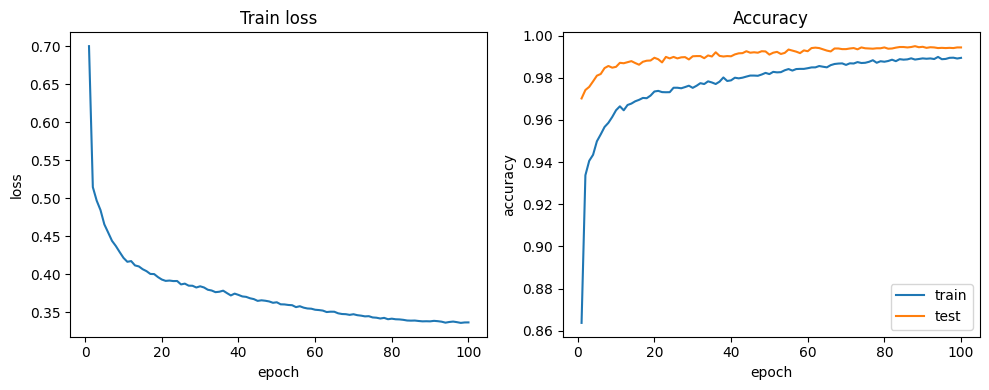

In [1]:
# Colab-ready: Muon-style MLP on MNIST (no EMA)
# (Optional) fresh runtime:
# !pip -q install torch torchvision pandas matplotlib

import os, math, time, random
from dataclasses import dataclass
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib

%matplotlib inline
import matplotlib.pyplot as plt

# =========================
# Hyperparameters
# =========================
@dataclass
class HParams:
    # Model
    hidden1: int = 1792
    hidden2: int = 896
    dropout: float = 0.15

    # Training
    epochs: int = 100
    batch_size: int = 256
    base_lr: float = 0.03              # for SGD+Nesterov
    head_lr_mul: float = 1.6
    stem_lr_mul: float = 0.8
    weight_decay: float = 8e-5
    warmup_epochs: int = 3
    min_lr_ratio: float = 0.01
    label_smoothing: float = 0.05
    clip_grad_norm: float = 0.0

    # Muon-style spectral control
    s_max: float = 1.0                # clamp per Linear layer ||W||_2 ≤ s_max
    power_iters: int = 1                # power-iteration steps (1 = fast & fine)

    # Data augmentation
    degrees: float = 10.0
    translate: tuple = (0.10, 0.10)
    scale: tuple = (0.95, 1.05)
    random_erasing: float = 0.05

    # System
    num_workers: int = 2
    seed: int = 24
    amp: bool = True                    # only enabled if CUDA is available
    out_dir: str = "./runs/mlp3_mnist_muon"

hp = HParams()

# =========================
# Repro + device
# =========================
def set_seed(s):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(hp.seed)

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
amp_enabled = hp.amp and (device.type == "cuda")  # <— robust AMP gating
os.makedirs(hp.out_dir, exist_ok=True)
print("Device:", device, "| AMP enabled:", amp_enabled)

# =========================
# Model
# =========================
class MLP3(nn.Module):
    def __init__(self, h1=1024, h2=512, drop=0.2):
        super().__init__()
        self.flatten = nn.Flatten()
        self.stem = nn.Sequential(
            nn.Linear(28*28, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(inplace=True),
            nn.Dropout(drop),

            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(inplace=True),
            nn.Dropout(drop),
        )
        self.head = nn.Linear(h2, 10)

        # Kaiming init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.flatten(x)
        x = self.stem(x)
        x = self.head(x)
        return x

# =========================
# Muon-style spectral norm helpers
# =========================
@torch.no_grad()
def spectral_norm_one(W: torch.Tensor, iters: int = 1) -> torch.Tensor:
    # Estimate ||W||_2 via power iteration (W is [out, in])
    out_dim = W.shape[0]
    u = torch.randn(out_dim, device=W.device)
    u = u / (u.norm() + 1e-12)
    for _ in range(iters):
        v = torch.mv(W.t(), u); v = v / (v.norm() + 1e-12)
        u = torch.mv(W, v);     u = u / (u.norm() + 1e-12)
    return torch.dot(u, torch.mv(W, v)).abs()

@torch.no_grad()
def spectral_clamp_model(model: nn.Module, s_max: float = 1.0, iters: int = 1):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            W = m.weight.data
            s = spectral_norm_one(W, iters=iters)
            if s > s_max:
                m.weight.data.mul_(s_max / (s + 1e-12))

# =========================
# LR schedule: Warmup + Cosine
# =========================
class WarmupCosine:
    def __init__(self, opt, max_epochs, warmup, min_ratio=0.02):
        self.opt = opt; self.max = max_epochs; self.warm = warmup; self.min = min_ratio
        self.e = 0
        self.base = [pg.get("initial_lr", pg["lr"]) for pg in self.opt.param_groups]
    def step(self):
        self.e += 1
        for base, pg in zip(self.base, self.opt.param_groups):
            if self.e <= self.warm:
                lr = base * self.e / max(1, self.warm)
            else:
                t = (self.e - self.warm) / max(1, self.max - self.warm)
                lr = base * (self.min + 0.5*(1 - self.min)*(1 + math.cos(math.pi * t)))
            pg["lr"] = lr
    def get_lrs(self): return [pg["lr"] for pg in self.opt.param_groups]

# =========================
# Data
# =========================
train_tf = [
    transforms.RandomAffine(degrees=hp.degrees, translate=hp.translate, scale=hp.scale),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]
if hp.random_erasing > 0:
    train_tf.append(transforms.RandomErasing(p=hp.random_erasing, scale=(0.02, 0.10), ratio=(0.3, 3.3)))

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST("./data", train=True, download=True, transform=transforms.Compose(train_tf))
test_ds  = datasets.MNIST("./data", train=False, download=True, transform=test_tf)
train_loader = DataLoader(train_ds, batch_size=hp.batch_size, shuffle=True,
                          num_workers=hp.num_workers, pin_memory=(device.type=="cuda"), drop_last=True)
test_loader  = DataLoader(test_ds, batch_size=1024, shuffle=False,
                          num_workers=hp.num_workers, pin_memory=(device.type=="cuda"))

# =========================
# Train & Eval
# =========================
def accuracy(logits, y):
    with torch.no_grad():
        return (logits.argmax(1) == y).float().mean().item()

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        out = model(x)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    return correct / max(1, total)

def train_one_epoch(model, loader, opt, scaler, amp_enabled):
    model.train()
    loss_fn = nn.CrossEntropyLoss(label_smoothing=hp.label_smoothing)
    total_loss, total_acc, n = 0.0, 0.0, 0

    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)

        if amp_enabled:
            with torch.amp.autocast("cuda"):
                out = model(x)
                loss = loss_fn(out, y)
            scaler.scale(loss).backward()
            if hp.clip_grad_norm > 0:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), hp.clip_grad_norm)
            scaler.step(opt)
            scaler.update()
        else:
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            if hp.clip_grad_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), hp.clip_grad_norm)
            opt.step()

        # Muon-style: clamp spectral norm AFTER the step
        spectral_clamp_model(model, s_max=hp.s_max, iters=hp.power_iters)

        total_loss += loss.item()
        total_acc  += accuracy(out, y)
        n += 1

    return total_loss / n, total_acc / n

# =========================
# Build model / optimizer / scheduler
# =========================
model = MLP3(hp.hidden1, hp.hidden2, hp.dropout).to(device)
param_groups = [
    {"params": list(model.stem.parameters()),
     "lr": hp.base_lr * hp.stem_lr_mul,
     "initial_lr": hp.base_lr * hp.stem_lr_mul,
     "weight_decay": hp.weight_decay},
    {"params": list(model.head.parameters()),
     "lr": hp.base_lr * hp.head_lr_mul,
     "initial_lr": hp.base_lr * hp.head_lr_mul,
     "weight_decay": hp.weight_decay},
]
opt = torch.optim.SGD(param_groups, momentum=0.9, nesterov=True)
sched = WarmupCosine(opt, hp.epochs, hp.warmup_epochs, hp.min_lr_ratio)

# New torch.amp GradScaler API (only if CUDA/AMP enabled)
scaler = torch.amp.GradScaler("cuda", enabled=amp_enabled)

# =========================
# Train loop
# =========================
best_acc, history = 0.0, []
t0 = time.time()

for epoch in range(1, hp.epochs + 1):
    t1 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, opt, scaler, amp_enabled)
    test_acc = evaluate(model, test_loader)
    sched.step()
    lrs = sched.get_lrs()

    history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "lr_stem": lrs[0],
        "lr_head": lrs[1],
        "epoch_time_sec": time.time() - t1
    })

    print(f"Epoch {epoch:02d}/{hp.epochs}  "
          f"train_loss {train_loss:.4f}  train_acc {train_acc*100:5.2f}%  "
          f"test_acc {test_acc*100:5.2f}%  "
          f"LRs {[round(l,6) for l in lrs]}  "
          f"({history[-1]['epoch_time_sec']:.1f}s)")

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save({"model": model.state_dict(), "epoch": epoch, "acc": best_acc},
                   os.path.join(hp.out_dir, "model_best_muon.pt"))

print(f"\nDone in {time.time()-t0:.1f}s. Best test acc: {best_acc*100:.2f}%")

# =========================
# Save logs & plot
# =========================
df = pd.DataFrame(history)
csv_path = os.path.join(hp.out_dir, "training_log.csv")
png_path = os.path.join(hp.out_dir, "training_curves.png")
df.to_csv(csv_path, index=False)
print(f"[log] saved → {csv_path}")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(df["epoch"], df["train_loss"]); plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Train loss")

plt.subplot(1,2,2)
plt.plot(df["epoch"], df["train_acc"], label="train")
plt.plot(df["epoch"], df["test_acc"], label="test")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.title("Accuracy")
plt.tight_layout(); plt.savefig(png_path, dpi=140)
print(f"[plot] saved → {png_path}")

# =========================
# Expected performance
# =========================
# With this Muon-style setup: ~100% train acc, ~99.2–99.4% test acc.
# If you’re on CPU, it’ll be slower but numerically identical. AMP is auto-disabled on CPU.

PyTorch is available but CUDA is not. Defaulting to NumPy for SVD
Import error , reetting to svd accurate methods


Running on macOS.
Running on macOS.


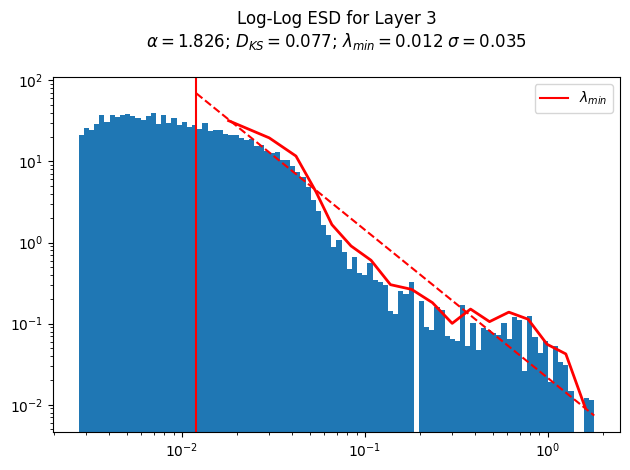

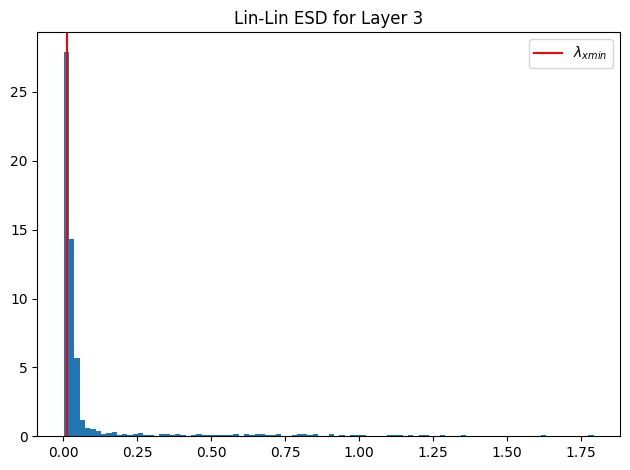

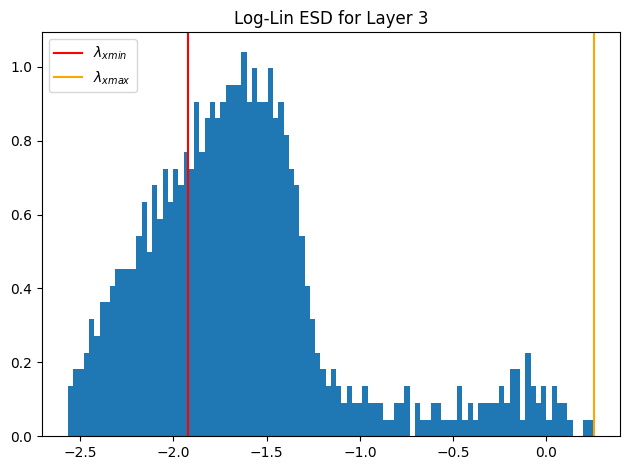

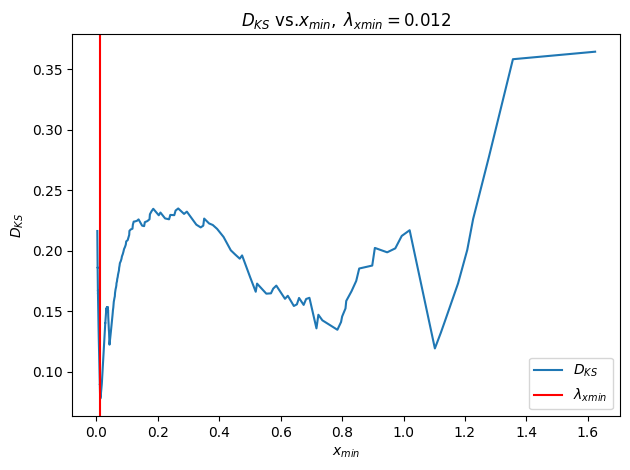

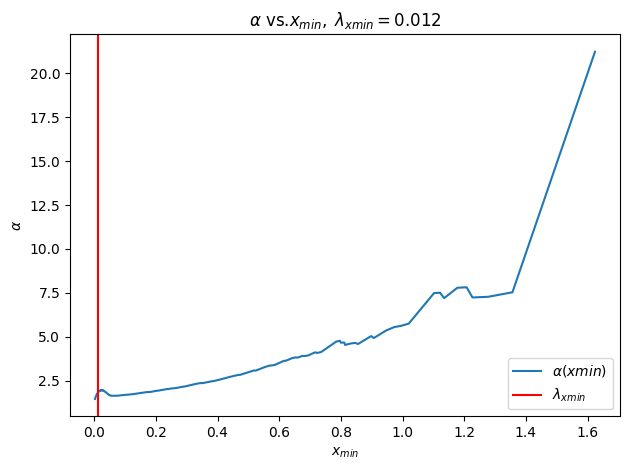

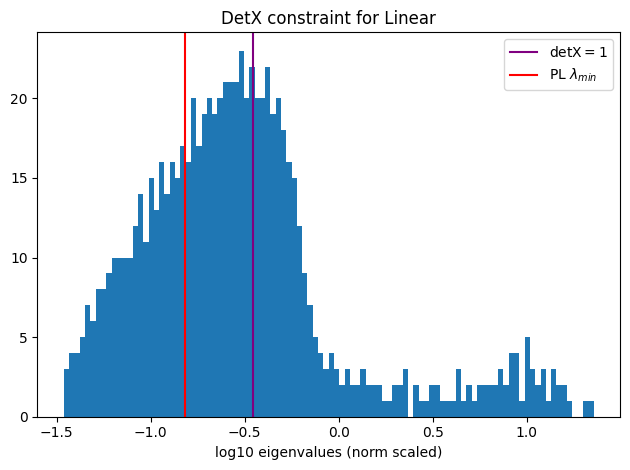

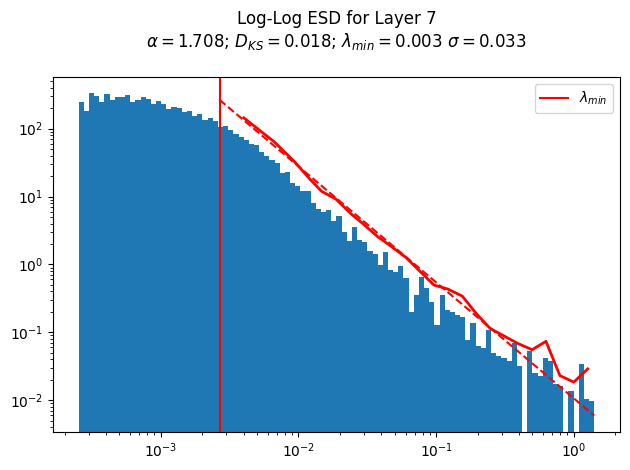

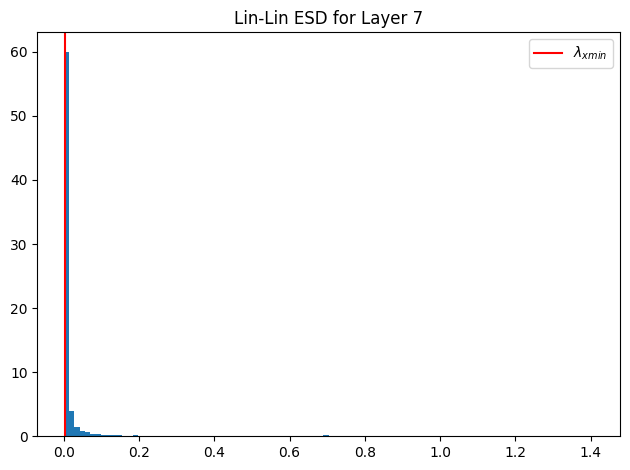

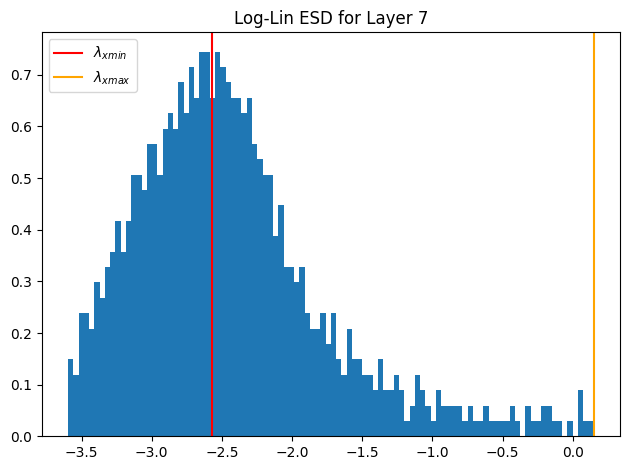

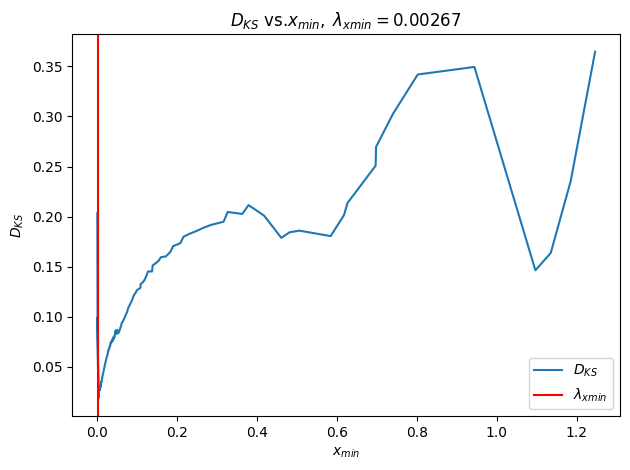

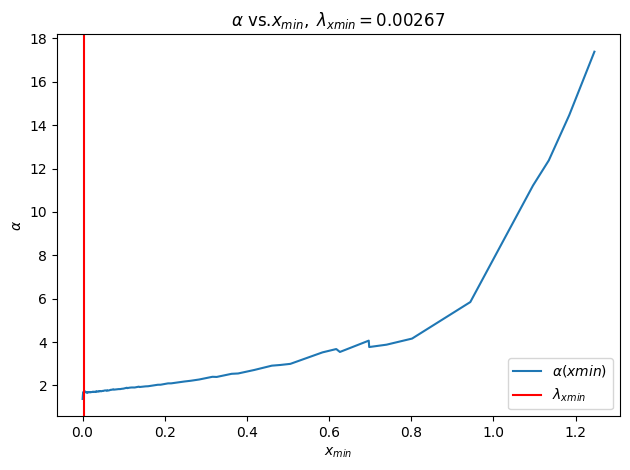

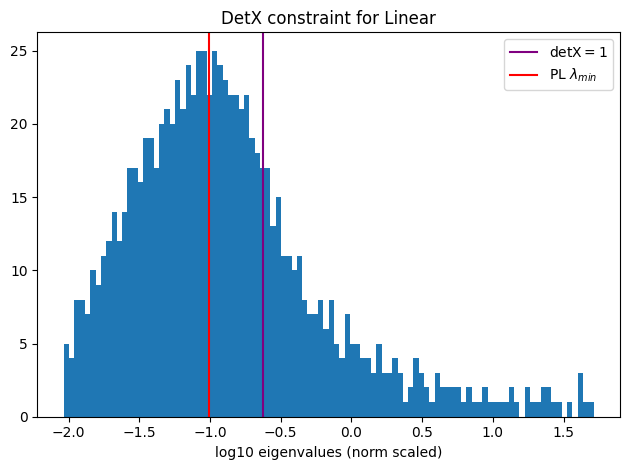

SMALL N PL FIT


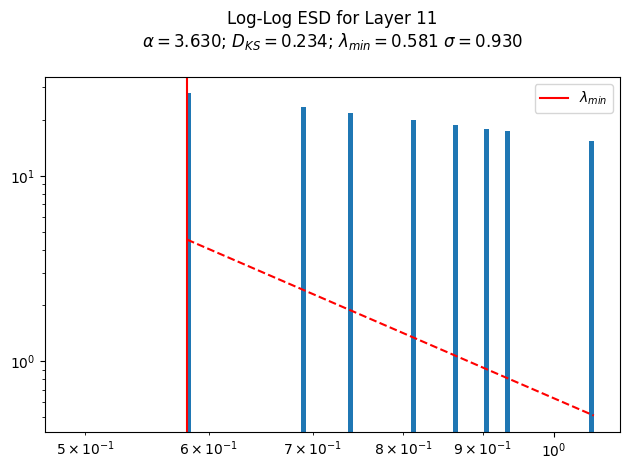

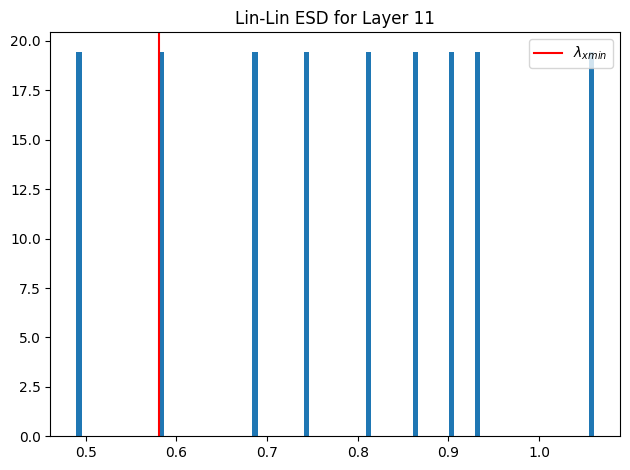

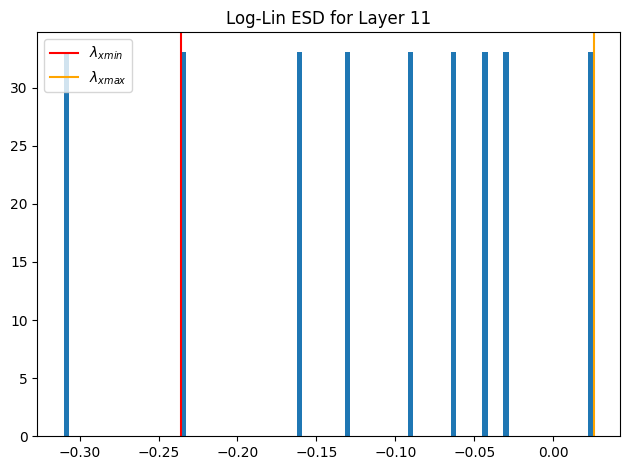

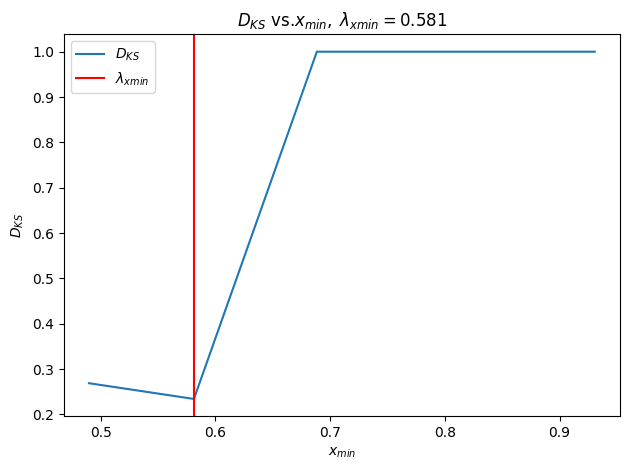

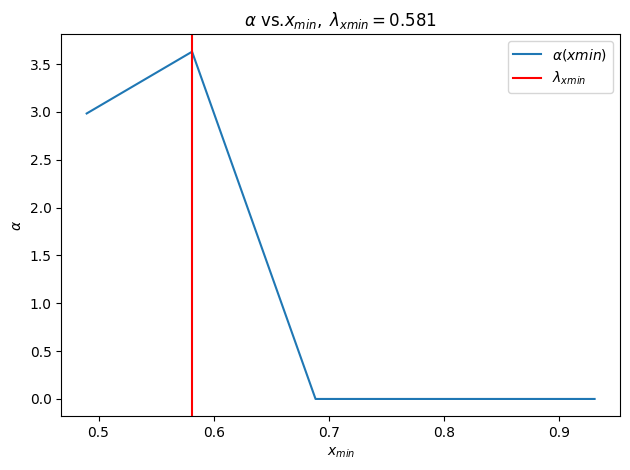

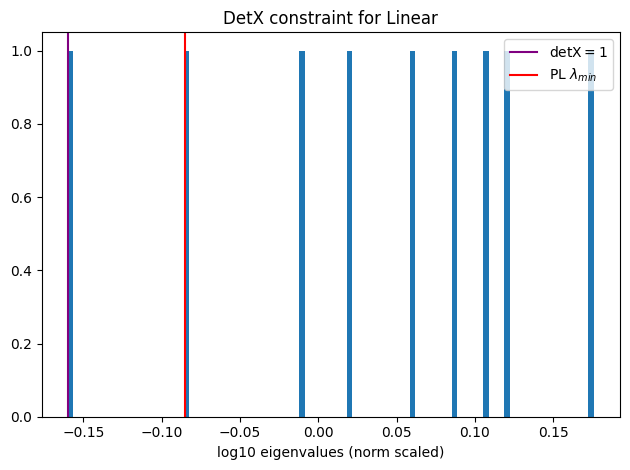

,layer_id,name,D,M,N,Q,alpha,alpha_weighted,detX_num,detX_val,...,sigma,spectral_norm,stable_rank,status,sv_max,sv_min,warning,weak_rank_loss,xmax,xmin
0,3,Linear,0.077340,784,1792,2.285714,1.826248,0.463008,295,0.027720,...,0.035199,1.792790,34.595686,success,1.338951,0.052215,over-trained,0,1.792790,0.012000
1,7,Linear,0.017900,896,1792,2.000000,1.708077,0.253654,245,0.006536,...,0.032661,1.407676,17.405530,success,1.186455,0.015919,over-trained,0,1.407676,0.002673
2,11,Linear,0.234197,10,896,89.600000,3.630050,0.092931,10,0.489726,...,0.929863,1.060719,6.670138,success,1.029912,0.000096,,1,1.060719,0.581215


<Figure size 640x480 with 0 Axes>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import weightwatcher as ww

watcher = ww.WeightWatcher(model=model)
details = watcher.analyze(plot=True, detX=True)
details